# Loading the Files

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d patrickfleith/nasa-battery-dataset

Dataset URL: https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset
License(s): copyright-authors
 99% 226M/228M [00:07<00:00, 37.0MB/s]
100% 228M/228M [00:07<00:00, 31.4MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/nasa-battery-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

# Importing the MetaData

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy.io import loadmat


In [ ]:
# We will use the matadata csv with start_time format to predict the SoH of a battery with cycle.
# SoH = Discharge Capacity/ Maximum rated capacity
metadata_df = pd.read_csv("/content/cleaned_dataset/metadata.csv")
metadata_df

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7560,impedance,[2010. 9. 30. 7. 36. ...,24,B0055,247,7561,07561.csv,NaN,0.0968087979207628,0.15489738203707232
7561,discharge,[2010. 9. 30. 8. 8. ...,4,B0055,248,7562,07562.csv,1.0201379996149256,NaN,NaN
7562,charge,[2010. 9. 30. 8. 48. 54.25],4,B0055,249,7563,07563.csv,NaN,NaN,NaN
7563,discharge,[2010. 9. 30. 11. 50. ...,4,B0055,250,7564,07564.csv,0.9907591663373165,NaN,NaN


In [ ]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 7565 non-null   object
 1   start_time           7565 non-null   object
 2   ambient_temperature  7565 non-null   int64 
 3   battery_id           7565 non-null   object
 4   test_id              7565 non-null   int64 
 5   uid                  7565 non-null   int64 
 6   filename             7565 non-null   object
 7   Capacity             2794 non-null   object
 8   Re                   1956 non-null   object
 9   Rct                  1956 non-null   object
dtypes: int64(3), object(7)
memory usage: 591.1+ KB


In [ ]:
# Removing the start_time
metadata_df.drop(columns = ['start_time','uid'], inplace = True)

In [ ]:
# Replace [] with np.nan in Capacity column
metadata_df.loc[metadata_df["Capacity"]=="[]", "Capacity"] = np.nan
metadata_df[metadata_df["Capacity"]=="[]"]["Capacity"]

Series([], Name: Capacity, dtype: object)

In [ ]:
# Grouping the battery as per similar test conditions of Temprature and other parameters.
# but every battery is unique and differ by Depth of Discharge.
battery_group = {"1": ["B0025", "B0026", "B0027", "B0028"],
                "2b": ["B0029", "B0030", "B0031", "B0032"],
                "2c": ["B0033", "B0034", "B0036"],
                "2d": ["B0038", "B0039", "B0040"],
                "2e": ["B0041", "B0042", "B0043", "B0044"],
                "3": ["B0045", "B0046", "B0047", "B0048"],
                "4": ["B0049", "B0050", "B0051", "B0052"],
                "5": ["B0053", "B0054", "B0055", "B0056"],
                "6": ["B0005", "B0006", "B0007", "B0018"]}

# Capacity & SoH Vs Cycle
Valid only for Discharge (capacity is the time taken by the battery to completely discharge)

In [ ]:
# Create box plots for each battery in each group
def plot_capacity_boxplot(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    capacity = []
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="discharge")].copy()
        clist = df[df["Capacity"].notna()]["Capacity"].astype(float).tolist()
        capacity.append(clist)
        print(len(clist))

    ax.boxplot(capacity)
    plt.legend()
    plt.ylim(-0.4,2.9)
    plt.xticks(range(1,len(cells[group]) + 1), cells[group])
    #plt.xlabel("Battery")
    plt.ylabel("Capacity [Ah]")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()


In [ ]:
def plot_capacity_vs_cycle(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="discharge")].copy()
        df["Capacity"] = df["Capacity"].astype(float)
        df["cycle"] = range(len(df))
        ax.plot(df["cycle"], df["Capacity"], marker='.', label=cell)

    plt.axhline(70.0, color='k', linestyle='--')
    plt.legend()
    plt.ylim(0,2.49)
    #plt.xlim(0,30)
    #plt.xlim(0,199)
    plt.xlabel("Cycle number")
    plt.ylabel("Capacity [Ah]")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

In [ ]:
def plot_SOH_vs_cycle(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="discharge")].copy()
        df["Capacity"] = df["Capacity"].astype(float)/2.0 * 100.0
        df["cycle"] = range(len(df))
        ax.plot(df["cycle"], df["Capacity"], marker='.', label=cell)

    plt.axhline(70.0, color='k', linestyle='--')
    plt.legend()
    plt.ylim(0,119)
    plt.xlim(0,199)
    plt.xlabel("Cycle number")
    plt.ylabel("SOH %")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

# Re and Rct Vs Cycel
Vaild only for Impedance

In [ ]:
def plot_Rct_vs_cycle(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="impedance")].copy()
        df["Rct"] = df["Rct"].astype(float)
        df["cycle"] = range(len(df))
        ax.plot(df["cycle"], df["Rct"], marker='.', label=cell)

    plt.axhline(70.0, color='k', linestyle='--')
    plt.legend()
    plt.ylim(0.05,0.15)
    #plt.xlim(0,30)
    plt.xlim(0,199)
    plt.xlabel("Cycle number")
    plt.ylabel("Rct")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

In [ ]:
def plot_Re_vs_cycle(cells: dict, group: str):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, ax = plt.subplots()
    for cell in cells[group]:
        df = metadata_df[(metadata_df["battery_id"]==cell) & (metadata_df["type"]=="impedance")].copy()
        df["Re"] = df["Re"].astype(float)
        df["cycle"] = range(len(df))
        ax.plot(df["cycle"], df["Re"], marker='.', label=cell)

    plt.axhline(70.0, color='k', linestyle='--')
    plt.legend()
    plt.ylim(0.02,0.1)
    #plt.xlim(0,30)
    plt.xlim(0,199)
    plt.xlabel("Cycle number")
    plt.ylabel("Re")
    plt.rcParams['axes.titley'] = 1.0 # title inside
    plt.rcParams['axes.titlepad'] = -14  # pad is in points...
    plt.title(f"Group {group}")
    plt.show()

# Plotting the curve w.r.t cycle count

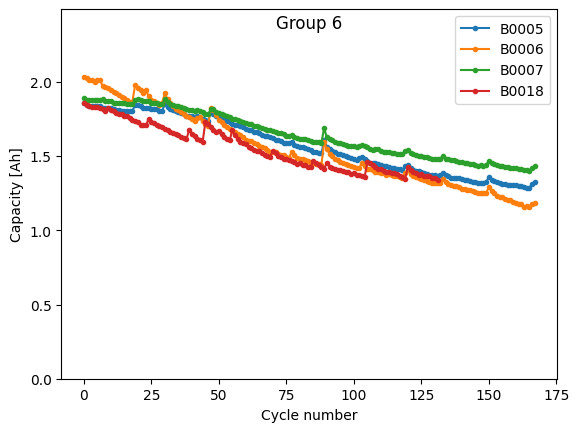

168
168
168
132


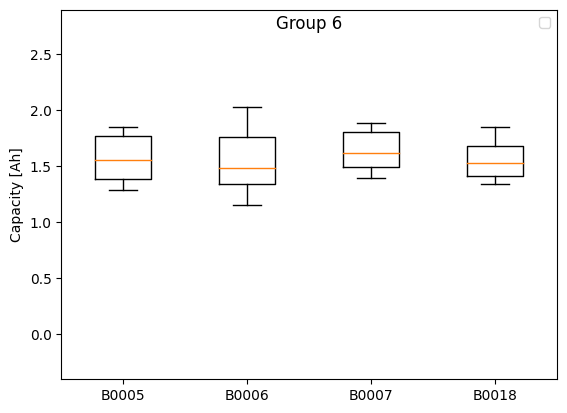

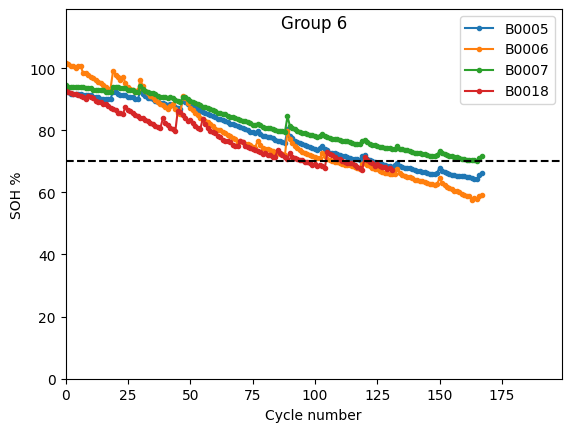

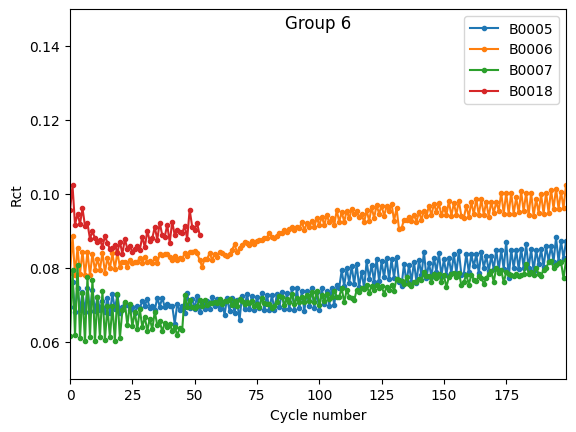

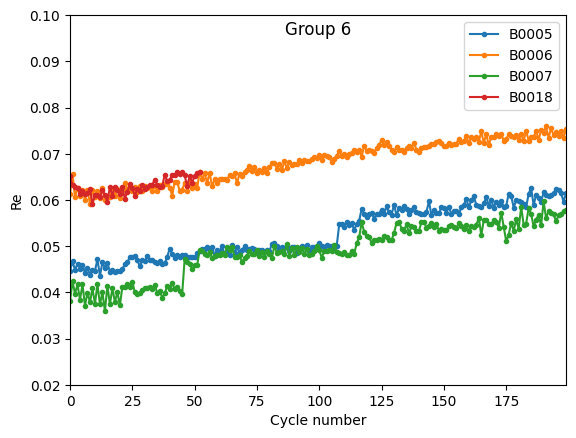

In [ ]:
GROUP = "6" # we can try various groups of battey eg 1,2a,2b,2c,2d,2e,3,4,5 only one of the group will be choosen for the test.
plot_capacity_vs_cycle(battery_group, GROUP)
plot_capacity_boxplot(battery_group, GROUP)
plot_SOH_vs_cycle(battery_group, GROUP)
plot_Rct_vs_cycle(battery_group, GROUP)
plot_Re_vs_cycle(battery_group, GROUP)

# A review to Metadata

In [ ]:
metadata_df[(metadata_df["battery_id"]=="B0005") & (metadata_df["type"]=="impedance")]


,type,ambient_temperature,battery_id,test_id,filename,Capacity,Re,Rct
5160,impedance,24,B0005,40,05161.csv,NaN,0.04466870036616091,0.06945627304536996
5162,impedance,24,B0005,42,05163.csv,NaN,0.04668700162486933,0.07627474098530587
5164,impedance,24,B0005,44,05165.csv,NaN,0.044843430573346096,0.0679720560130687
5166,impedance,24,B0005,46,05167.csv,NaN,0.04619468955099375,0.07453388918437964
5168,impedance,24,B0005,48,05169.csv,NaN,0.04510114851143001,0.06852832896000328
...,...,...,...,...,...,...,...,...
5724,impedance,24,B0005,604,05725.csv,NaN,0.05880084419395591,0.08236983437565949
5726,impedance,24,B0005,606,05727.csv,NaN,0.05763029720163586,0.08742389347930328
5728,impedance,24,B0005,608,05729.csv,NaN,0.05898388938334406,0.08252211755101288
5730,impedance,24,B0005,610,05731.csv,NaN,0.057823749393303175,0.08975687046479841


In [ ]:
metadata_df[(metadata_df["battery_id"]=="B0005") & (metadata_df["type"]=="discharge")]

,type,ambient_temperature,battery_id,test_id,filename,Capacity,Re,Rct,Group
5121,discharge,24,B0005,1,05122.csv,1.8564874208181574,NaN,NaN,6
5123,discharge,24,B0005,3,05124.csv,1.846327249719927,NaN,NaN,6
5125,discharge,24,B0005,5,05126.csv,1.8353491942234077,NaN,NaN,6
5127,discharge,24,B0005,7,05128.csv,1.8352625275821128,NaN,NaN,6
5129,discharge,24,B0005,9,05130.csv,1.8346455082120419,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...
5719,discharge,24,B0005,599,05720.csv,1.293463613844243,NaN,NaN,6
5723,discharge,24,B0005,603,05724.csv,1.288003392619118,NaN,NaN,6
5727,discharge,24,B0005,607,05728.csv,1.2874525221379407,NaN,NaN,6
5731,discharge,24,B0005,611,05732.csv,1.3090153642307354,NaN,NaN,6


In [ ]:

# Label each battery with their group
metadata_df["Group"] = ""
for key in list(battery_group.keys()):
    for cell in battery_group[key]:
        metadata_df.loc[metadata_df["battery_id"]==cell, "Group"] = key

metadata_df

,type,ambient_temperature,battery_id,test_id,filename,Capacity,Re,Rct,Group
0,discharge,4,B0047,0,00001.csv,1.6743047446975208,NaN,NaN,3
1,impedance,24,B0047,1,00002.csv,NaN,0.05605783343888099,0.20097016584458333,3
2,charge,4,B0047,2,00003.csv,NaN,NaN,NaN,3
3,impedance,24,B0047,3,00004.csv,NaN,0.05319185850921101,0.16473399914864734,3
4,discharge,4,B0047,4,00005.csv,1.5243662105099023,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...
7560,impedance,24,B0055,247,07561.csv,NaN,0.0968087979207628,0.15489738203707232,5
7561,discharge,4,B0055,248,07562.csv,1.0201379996149256,NaN,NaN,5
7562,charge,4,B0055,249,07563.csv,NaN,NaN,NaN,5
7563,discharge,4,B0055,250,07564.csv,0.9907591663373165,NaN,NaN,5


In [ ]:
# Type of the batteries
battery_ids = metadata_df["battery_id"].value_counts().index
battery_ids

Index(['B0007', 'B0005', 'B0006', 'B0033', 'B0036', 'B0034', 'B0018', 'B0044',
       'B0043', 'B0042', 'B0054', 'B0056', 'B0055', 'B0047', 'B0048', 'B0045',
       'B0046', 'B0041', 'B0053', 'B0040', 'B0039', 'B0038', 'B0030', 'B0029',
       'B0031', 'B0032', 'B0026', 'B0025', 'B0028', 'B0027', 'B0049', 'B0052',
       'B0051', 'B0050'],
      dtype='object', name='battery_id')

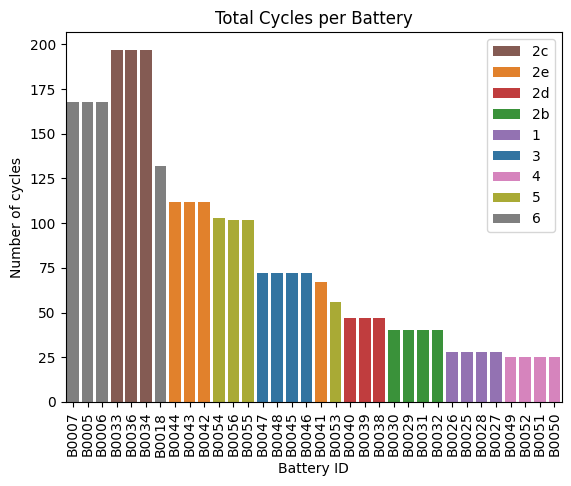

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
sns.countplot(data=metadata_df[metadata_df["type"]=="discharge"], x="battery_id", order=battery_ids, dodge=False, hue=metadata_df["Group"])
plt.tick_params(axis='x', rotation=90)
plt.ylabel("Number of cycles")
plt.xlabel("Battery ID")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [5,1,3,2,4,0,6,8,7] # Quite confusing

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper right")

plt.title('Total Cycles per Battery')
plt.show()

# Loading the Time-series Data

In [ ]:
# sample dataset
df_discharge = pd.read_csv("/content/cleaned_dataset/data/00001.csv")
df_charge = pd.read_csv("/content/cleaned_dataset/data/00003.csv")
df_impedance = pd.read_csv("/content/cleaned_dataset/data/00002.csv")
df_discharge_final = pd.read_csv("/content/cleaned_dataset/data/00181.csv")

In [ ]:
df_discharge

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625
...,...,...,...,...,...,...
485,3.303251,-0.001760,9.662331,0.0004,0.000,6382.063
486,3.310303,-0.000756,9.390489,0.0002,0.000,6395.547
487,3.317351,-0.003318,9.137008,0.0002,0.000,6409.063
488,3.323387,-0.002291,8.972806,0.0002,0.000,6422.625


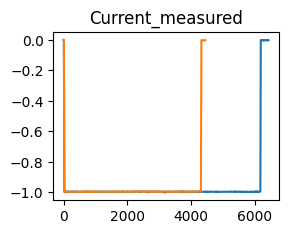

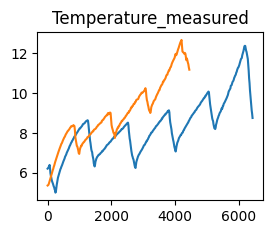

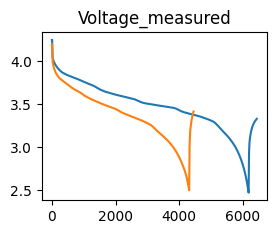

In [ ]:
# df_dicharge line curves
volt = df_discharge['Voltage_measured']
volt_f = df_discharge_final['Voltage_measured']
time = df_discharge['Time']
time_f = df_discharge_final['Time']
curr = df_discharge['Current_measured']
curr_f = df_discharge_final['Current_measured']
temp = df_discharge['Temperature_measured']
temp_f = df_discharge_final['Temperature_measured']
curlo = df_discharge['Current_load']
curlo_f = df_discharge_final['Current_load']
vollo = df_discharge['Voltage_load']
vollo_f = df_discharge_final['Voltage_load']

plt.subplot(2,2,1)
plt.title("Current_measured")
plt.plot(time,curr)
plt.plot(time_f,curr_f)
plt.show()

plt.subplot(2,2,2)
plt.title("Temperature_measured")
plt.plot(time, temp)
plt.plot(time_f, temp_f)
plt.show()

plt.subplot(2,2,3)
plt.title("Voltage_measured")
plt.plot(time, volt)
plt.plot(time_f, volt_f)
plt.show()


In [ ]:
df_charge

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time
0,3.486189,0.001417,5.990142,-0.0006,0.002,0.000
1,3.746592,1.489057,5.992528,1.4995,4.618,2.594
2,3.775438,1.490426,5.991340,1.4995,4.669,8.922
3,3.794844,1.491527,6.003554,1.4995,4.694,15.234
4,3.811691,1.491425,6.026729,1.4995,4.707,21.516
...,...,...,...,...,...,...
1616,4.213930,0.053584,5.650154,0.0534,4.263,10776.438
1617,4.214202,0.053244,5.669955,0.0534,4.263,10783.156
1618,4.213894,0.054503,5.687639,0.0534,4.263,10789.875
1619,4.214060,0.051309,5.708888,0.0534,4.263,10796.578


In [ ]:
df_impedance

,Sense_current,Battery_current,Current_ratio,Battery_impedance,Rectified_Impedance
0,(928.3472290039062-48.499576568603516j),(228.7861328125-70.94481658935547j),(3.76172584438583+0.9544956717274271j),(0.19021741554080737+0.07913959666077047j),(0.17493022756754967-0.02331644173631698j)
1,(922.0059814453125-52.15481185913086j),(233.29783630371094-67.84492492675781j),(3.70383574337748+0.8535511912426126j),(0.012482111540534805+0.03664975726191017j),(0.16866854345060991-0.024717137242854174j)
2,(920.0405883789062-52.19926452636719j),(236.62075805664062-67.22105407714844j),(3.6558702379340415+0.8179848126025503j),(0.030461237041852884-0.08529386061204824j),(0.16107808875912483-0.024114907529065532j)
3,(914.2005615234375-52.371726989746094j),(242.2973175048828-66.45936584472656j),(3.564190338159781+0.7614698525522733j),(0.14229365598447172-0.12192216177062407j),(0.14924381603096853-0.02372905366581296j)
4,(911.2781372070312-45.477928161621094j),(246.62347412109375-65.4150161743164j),(3.4978434135716947+0.7433743116536402j),(0.24388219819020493-0.08033187245076714j),(0.14049811021506395-0.022851601640846698j)
5,(907.116943359375-46.32453536987305j),(251.11593627929688-65.69110107421875j),(3.426140647581949+0.7117924049476518j),(0.303109266599245-0.01100015291136107j),(0.1311573351226623-0.02242361032794129j)
6,(899.554443359375-43.06085968017578j),(259.12646484375-67.00004577636719j),(3.2942234027295925+0.6855813018072434j),(0.32709058487432013+0.05145705088260462j),(0.12304603255413803-0.0195099331278606j)
7,(891.207275390625-43.172672271728516j),(266.564697265625-68.21566772460938j),(3.176714891409828+0.6509828833170116j),(0.33089967640944123+0.09355670635190765j),(0.11344810854459421-0.017644032709853628j)
8,(885.2266845703125-43.83500289916992j),(273.4709777832031-69.10552978515625j),(3.080782312186481+0.6182158425280606j),(0.3254359075820158+0.11409318785479901j),(0.10803339194768323-0.01638562897701378j)
9,(877.4107666015625-43.043678283691406j),(281.1755065917969-67.8630599975586j),(2.9836528086978147+0.5670342101181585j),(0.31603270085729296+0.1168731107735024j),(0.10034982474252357-0.013454518333835989j)


In [ ]:
# finding the absolute value of the complex number in df_impedance
def absolute_value (file):
  column_names = list(file.columns)
  for column in column_names:
    file[f'{column}'] = file[f'{column}'].astype('complex128').abs()
  return file

df_impedance = absolute_value(df_impedance)

In [ ]:
df_impedance

,Sense_current,Battery_current,Current_ratio,Battery_impedance,Rectified_Impedance
0,929.613246,239.533425,3.880933,0.206024,0.176477
1,923.479915,242.962578,3.800914,0.038717,0.170470
2,921.520183,245.983848,3.746263,0.090570,0.162873
3,915.699440,251.246567,3.644625,0.187383,0.151118
4,912.412234,255.151450,3.575963,0.256772,0.142344
5,908.299021,259.566050,3.499298,0.303309,0.133060
6,900.584496,267.648148,3.364808,0.331113,0.124583
7,892.252368,275.154711,3.242730,0.343871,0.114812
8,886.311340,282.067279,3.142198,0.344856,0.109269
9,878.465942,289.249132,3.037056,0.336951,0.101248


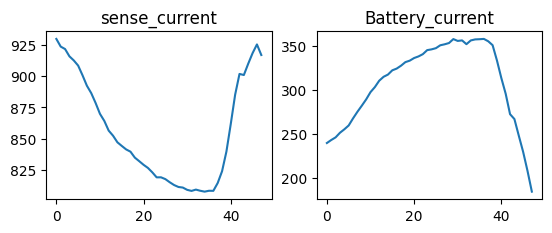

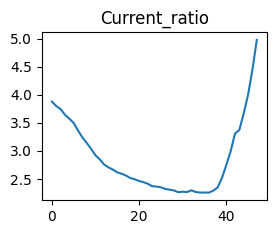

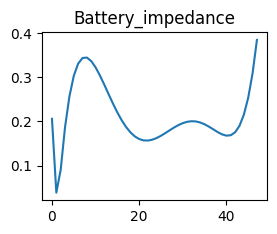

In [ ]:
# line graph of df_impedance
plt.subplot(2,2,1)
plt.title("sense_current")
plt.plot(df_impedance["Sense_current"])
plt.show

plt.subplot(2,2,2)
plt.title("Battery_current")
plt.plot(df_impedance["Battery_current"])
plt.show()

plt.subplot(2,2,3)
plt.title("Current_ratio") # it is the ratio of sense_current and battery curret
plt.plot(df_impedance["Current_ratio"])
plt.show()

plt.subplot(2,2,4)
plt.title("Battery_impedance")
plt.plot(df_impedance["Battery_impedance"])
plt.show()


# Plotting various discharge curve w.r.t time
for all discharge profile vs time

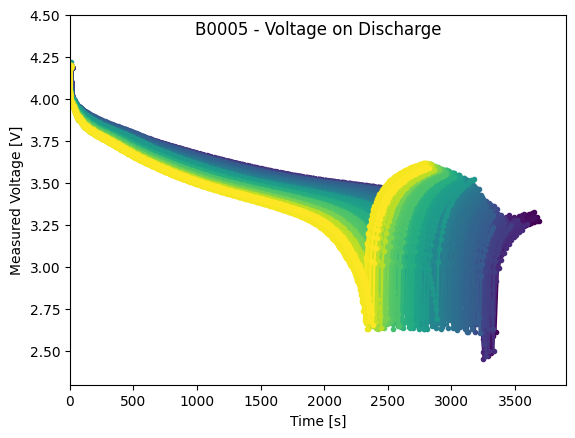

In [ ]:
# Plot voltage vs time during discharging cycle
BATTERY_ID = "B0005"
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="discharge")]['filename'].tolist()

cycle = 1
N = len(filenames)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
fig, ax = plt.subplots()

for filename in filenames:
    battery_data = pd.read_csv(f"/content/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Voltage_measured"], marker='.', label=cycle)
    cycle += 1

plt.ylim(2.3,4.5)
plt.xlim(0,3900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Voltage [V]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Voltage on Discharge")
plt.show()

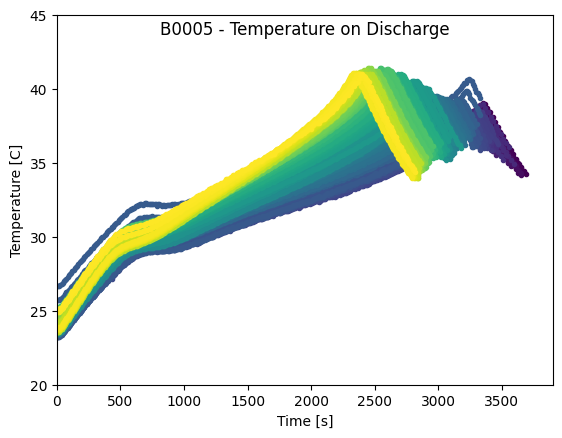

In [ ]:
# Plot temprature Vs time duiring discharge cycle

BATTERY_ID = "B0005"
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="discharge")]['filename'].tolist()

cycle = 1
N = len(filenames)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
fig, ax = plt.subplots()

for filename in filenames:
    battery_data = pd.read_csv(f"/content/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Temperature_measured"], marker='.', label=cycle)
    cycle += 1

plt.ylim(20,45)
plt.xlim(0,3900)
plt.xlabel("Time [s]")
plt.ylabel("Temperature [C]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Temperature on Discharge")
plt.show()


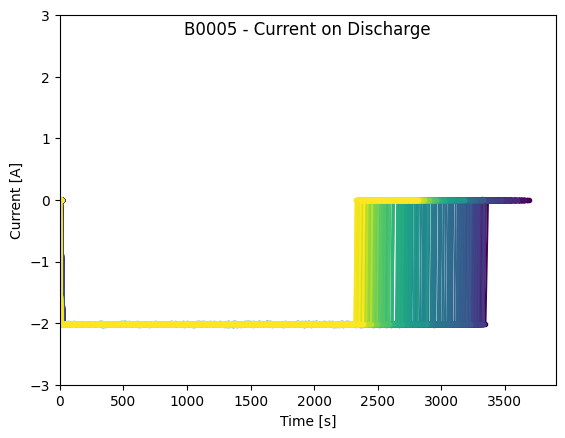

In [ ]:
# Plot current_measured Vs time duiring discharge cycle

BATTERY_ID = "B0005"
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="discharge")]['filename'].tolist()

cycle = 1
N = len(filenames)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
fig, ax = plt.subplots()

for filename in filenames:
    battery_data = pd.read_csv(f"/content/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Current_measured"], marker='.', label=cycle)
    cycle += 1

plt.ylim(-3,3)
plt.xlim(0,3900)
plt.xlabel("Time [s]")
plt.ylabel("Current [A]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Current on Discharge")
plt.show()


# Plotting Various charge curve Vs time
for all charge profile Vs time

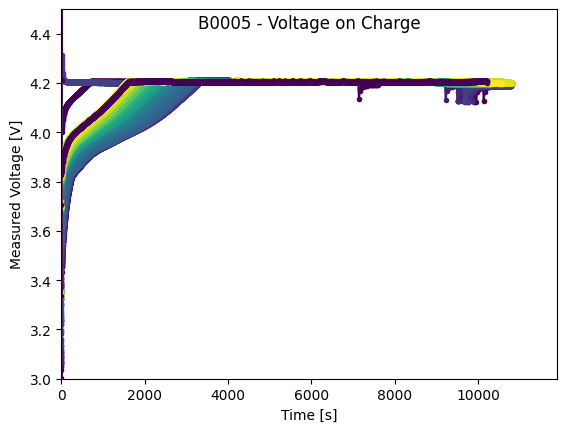

In [ ]:
# Plot voltage vs time during charging cycles
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="charge")]['filename'].tolist()

fig, ax = plt.subplots()
cycle = 1
for filename in filenames:
    battery_data = pd.read_csv(f"/content/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Voltage_measured"], marker='.', label=cycle)
    cycle += 1

plt.ylim(3,4.5)
plt.xlim(0,11900)
plt.xlabel("Time [s]")
plt.ylabel("Measured Voltage [V]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Voltage on Charge")
plt.show()

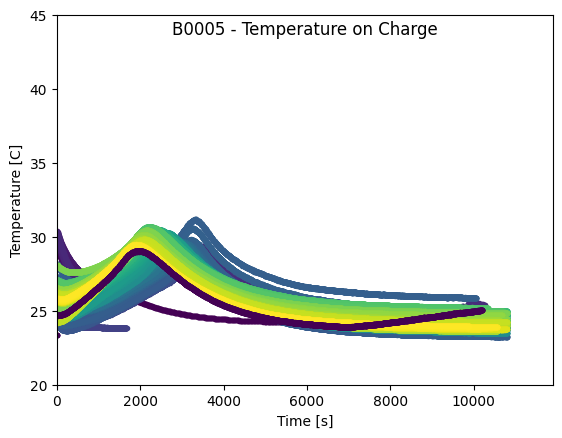

In [ ]:
# Plot temperature vs time during Charging cycles

BATTERY_ID = "B0005"
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="charge")]['filename'].tolist()

fig, ax = plt.subplots()
cycle = 1
for filename in filenames:
    battery_data = pd.read_csv(f"/content/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Temperature_measured"], marker='.', label=cycle)
    cycle += 1

plt.ylim(20,45)
plt.xlim(0,11900)
plt.xlabel("Time [s]")
plt.ylabel("Temperature [C]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Temperature on Charge")
plt.show()


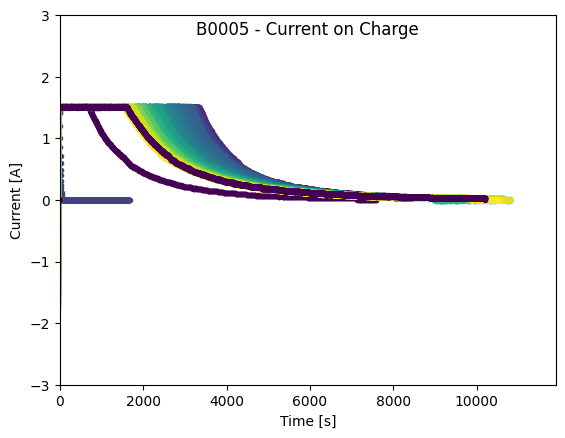

In [ ]:
# Plot Current vs time during charging cycles

BATTERY_ID = "B0005"
filenames = metadata_df[(metadata_df["battery_id"]==BATTERY_ID) & (metadata_df["type"]=="charge")]['filename'].tolist()

fig, ax = plt.subplots()
cycle = 1
for filename in filenames:
    battery_data = pd.read_csv(f"/content/cleaned_dataset/data/{filename}")
    ax.plot(battery_data["Time"], battery_data["Current_measured"], marker='.', label=cycle)
    cycle += 1

plt.ylim(-3,3)
plt.xlim(0,11900)
plt.xlabel("Time [s]")
plt.ylabel("Current [A]")
plt.rcParams['axes.titley'] = 1.0 # title inside
plt.rcParams['axes.titlepad'] = -14  # pad is in points...
plt.title(f"{BATTERY_ID} - Current on Charge")
plt.show()

